## Advanced Relational Database and SQL

This is a project-based course which should take approximately 1.5 hours to finish. Before diving into the project, please take a look at the course objectives and structure.

MySQL workbench based on Oracle SQL 

#### Course Objectives

- Advanced SQL topics including functions, stored procedures, triggers, common table expressions and recursion.

- How to generate end-user-facing data presentations with advanced SQL.

#### Task 1 - User interface orientation

Please note that the SQL CODE is meant to run on SQL workbench and is not a python function.

# Tasks (1 to 7B) 

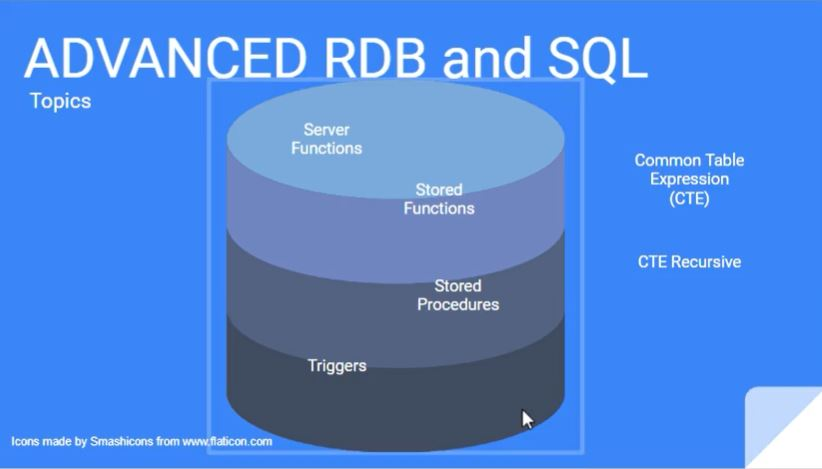

--
-- Welcome to Task 2 !!
--
-- Learn and write server functions
--
-- Server Functions

USE world_peace;

-- aggregate functions
SELECT COUNT(*) FROM customer;

SELECT MAX(qoh) FROM merchandise_item;

SELECT MIN(unit_price)/100 FROM merchandise_item;

SELECT AVG(unit_price)/100 AS average_price
FROM merchandise_item;


-- TODO --

-- Write an SQL statement to:
-- find the sum of the column quantity
-- the function is SUM( )
-- in the table customer_order_line_item

SELECT SUM(quantity) FROM customer_order_line_item;


-- Non-aggregate functions

SELECT FORMAT(unit_price/100, 2, "en_IN") AS unit_price_decimal 
-- FORMAT - defines the format in data is displayed
-- 2 - number of decimal places
-- en_IN - locale specific format
FROM merchandise_item;

SELECT CONCAT(CHAR_LENGTH(description), " chars")
FROM merchandise_item;

-- TODO --

-- Write an SQL statement to:

-- find the average all the unit_price in the table merchandise_item
-- (don't forget to divide it by 100)
-- format it to 2 decimal places and use country code "en_IN" for Indian English
-- add the Rupee symbol ? in front of it, copy and paste it if you'd like

SELECT CONCAT("? ", FORMAT(AVG(unit_price)/100, 2, "en_IN")) AS AveragePrice
FROM merchandise_item;



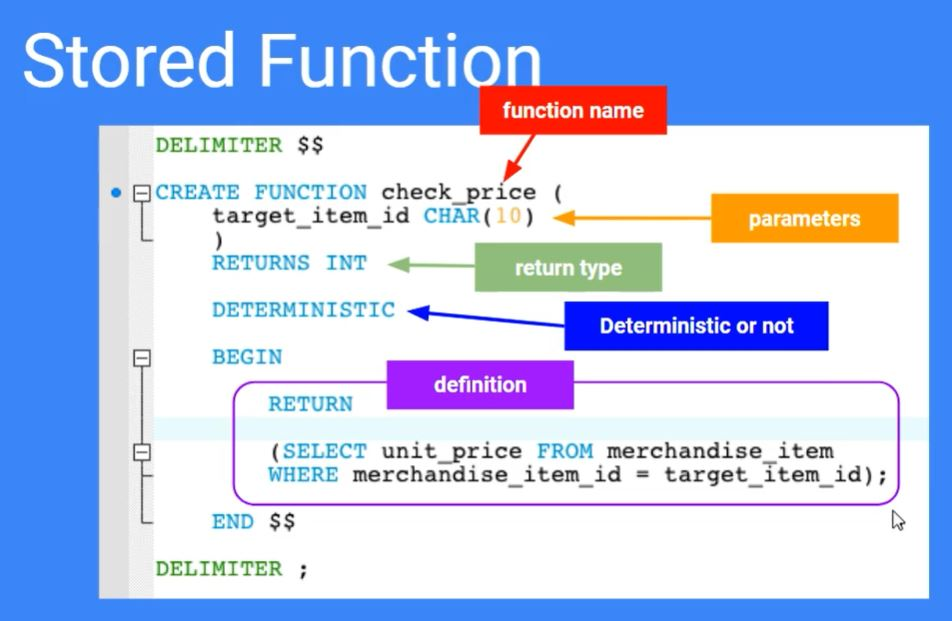

--
-- Welcome to Task 3 !!
--
-- Advanced RDB and SQL
--
-- Stored Functions
--

USE world_peace;

DROP FUNCTION IF EXISTS check_credit;

DELIMITER $$

CREATE FUNCTION check_credit (
	requesting_customer_id CHAR(10),
	request_amount INT
    )
RETURNS BOOLEAN

DETERMINISTIC

BEGIN

	RETURN
	
	(
	-- TODO --
	-- write an SQL to select the credit_limit
	-- from table customer
	-- for customer_id matching requesting_customer_id
    SELECT credit_limit 
    FROM CUSTOMER
    WHERE customer_id = requesting_customer_id
	) >= request_amount;

END $$

DELIMITER ;

-- check to see if the function works
SET @approved = check_credit("C000000001", 4000000);
SELECT @approved;

-- -------------------------------------------------

DROP FUNCTION IF EXISTS get_qoh_ftn;

DELIMITER $$

CREATE FUNCTION get_qoh_ftn (
	request_item_id CHAR(10)
    )
RETURNS INT
    
DETERMINISTIC
    
BEGIN

	RETURN 
    (
	-- TODO --
	-- write an SQL to select the qoh (quantity on hand)
    -- from table merchandise_item
	-- for merchandise_item_id matching request_item_id
    SELECT qoh 
    FROM merchandise_item
    WHERE merchant_item_id = order_item_id
    );


END $$
    
DELIMITER ;


-- check to see if the function works
SET @qty = get_qoh_ftn("KYOTOCBOOK");
SELECT @qty;

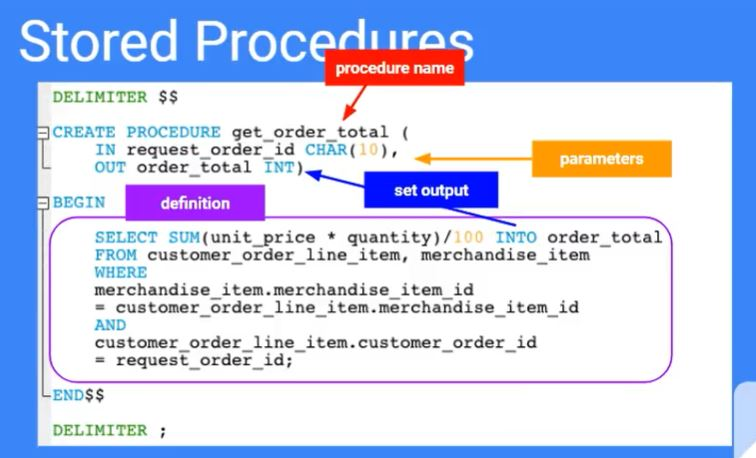

--
-- Welcome to Task 4 !!
--
-- Advanced RDB and SQL
--
-- Stored Procedure
-- 

USE world_peace;

DROP PROCEDURE IF EXISTS customer_roster_stp;

DELIMITER $$

CREATE PROCEDURE customer_roster_stp()

BEGIN

	-- TODO --
	-- write an SQL to select all the customer
	-- from table customer
    -- sort it by customer_name
    SELECT *
    FROM customer 
    ORDER BY customer_name;

END $$

DELIMITER ;

-- check to see if it works
CALL customer_roster_stp();

-- --------------

DROP PROCEDURE IF EXISTS get_qoh_stp;

DELIMITER $$

CREATE PROCEDURE get_qoh_stp(
	IN request_item_id CHAR(10),
    OUT qoh_to_return INT)
    
BEGIN

	-- TODO --
	-- write an SQL to select the qoh (quantity on hand)
    -- from table merchandise_item
	-- for merchandise_item_id matching request_item_id
    -- note that your statement will not run yet
    SELECT qoh INTO qoh_to_return
    FROM merchandise_item
    WHERE merchandise_item_id = request_item_id;
    
    
END$$

DELIMITER ;

SET @qty = 0;
CALL get_qoh_stp("ITALYPASTA", @qty);
SELECT @qty;

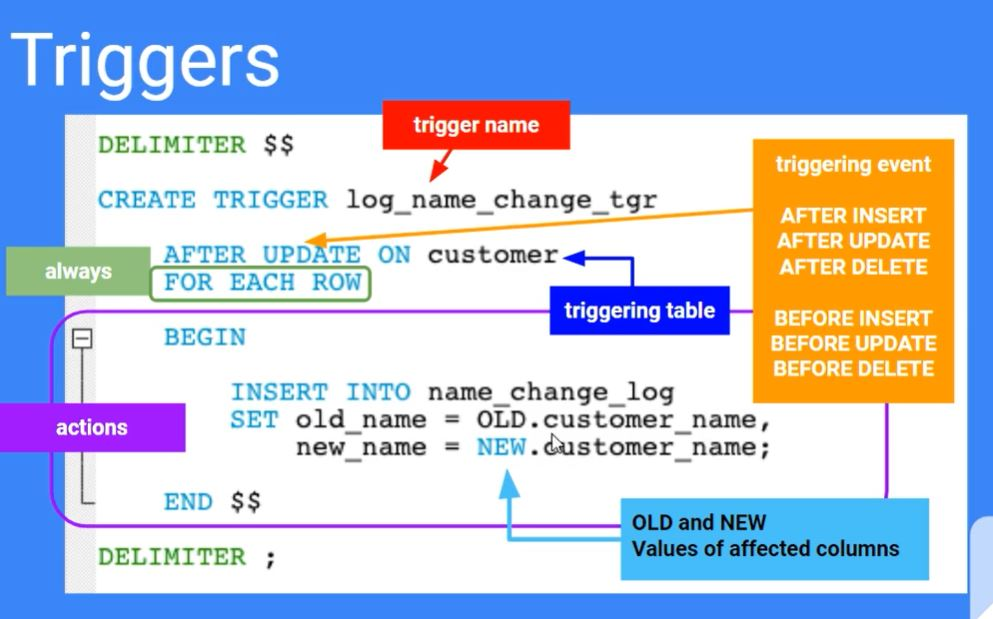

In [5]:
# Triggering events
# AFTER/BEFORE INSERT/UPDATE/DELETE ON table_name
# FOR EACH ROW

--
-- Welcome to Task 5 !!
--
-- Advanced RDB and SQL
--
-- Triggers
--

USE world_peace;

DROP TRIGGER IF EXISTS decrease_inventory_tgr;

-- decrease qoh (quantity on hand) after inserting a new line item
-- into the table customer_order_line_item

DELIMITER $$

CREATE TRIGGER decrease_inventory_tgr

	AFTER INSERT ON customer_order_line_item
    
    FOR EACH ROW
    
    BEGIN
    
		UPDATE merchandise_item
        SET qoh = qoh - NEW.quantity
        WHERE merchandise_item_id = NEW.merchandise_item_id;
        
	END $$

DELIMITER ;


-- check qoh (quantity on hand) before inserting a new line item
-- into the table customer_order_line_item

DROP TRIGGER IF EXISTS inventory_check_tgr;

DELIMITER $$

CREATE TRIGGER inventory_check_tgr

	BEFORE INSERT ON customer_order_item
    FOR EACH ROW

BEGIN
           
	-- using stored function
           
-- 	IF (get_qoh_ftn(NEW.merchandise_item_id) < NEW.quantity) THEN
-- 		SIGNAL SQLSTATE "45000"
-- 		SET MESSAGE_TEXT = "Insufficient inventory";
-- 	END IF;
        
	-- using stored procedure
    
    DECLARE inventory INT;
    
    CALL get_qoh_stp(NEW.merchandise_item_id, inventory);
    
	IF (inventory < NEW.quantity) THEN
		SIGNAL SQLSTATE "45000"
		SET MESSAGE_TEXT = "Insufficient inventory";
	END IF;
    
	-- doing it from stratch
        
-- 	DECLARE inventory INT;
-- 	
--     SELECT qoh INTO inventory
-- 	FROM merchandise_item
-- 	WHERE merchandise_item_id = NEW.merchandise_item_id;

-- 	IF (inventory < NEW.quantity) THEN
-- 		SIGNAL SQLSTATE "45000"
-- 		SET MESSAGE_TEXT = "Insufficient inventory";
-- 	END IF;
        
END $$
        
DELIMITER ;

-- check to see if it works!

UPDATE merchandise_item
SET qoh = 10
WHERE merchandise_item_id = "ITALYPASTA";

DELETE FROM customer_order_line_item
WHERE customer_order_id = "D000000003" AND
merchandise_item_id = "ITALYPASTA";

INSERT INTO customer_order_line_item
SET 
customer_order_id = "D000000003",
merchandise_item_id = "ITALYPASTA",
quantity = 20;

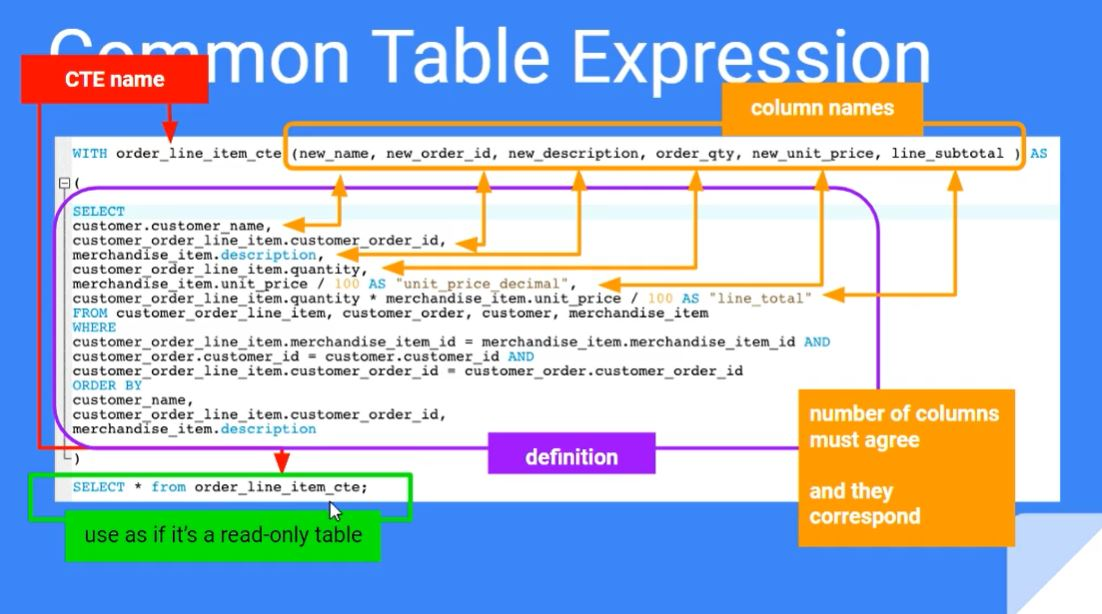

In [7]:
# Functions, procedures, triggers are entities which are saved in the database. 
# However, CTEs are not entities which are saved on the database. It is saved as a ".sql" file 


-- customer orders.sql

SELECT
customer.customer_name,
customer_order_line_item.customer_order_id,
merchandise_item.description,
customer_order_line_item.quantity,
merchandise_item.unit_price / 100 AS "unit_price_decimal",
customer_order_line_item.quantity * merchandise_item.unit_price / 100 AS "line_total"
FROM customer_order_line_item, customer_order, customer, merchandise_item
WHERE
customer_order_line_item.merchandise_item_id = merchandise_item.merchandise_item_id AND
customer_order.customer_id = customer.customer_id AND
customer_order_line_item.customer_order_id = customer_order.customer_order_id
ORDER BY
customer_name,
customer_order_line_item.customer_order_id,
merchandise_item.description

--
-- Welcome to Task 6 !!
--
-- Advanced RDB and SQL
--
-- Common Table Expressions
-- 

USE world_peace;

WITH order_line_item_cte (new_name, new_order_id, new_description, order_qty, new_unit_price, line_subtotal ) AS

(

-- TODO -----> Paste the customer order SQL here

-- customer orders.sql

SELECT
customer.customer_name,
customer_order_line_item.customer_order_id,
merchandise_item.description,
customer_order_line_item.quantity,
merchandise_item.unit_price / 100 AS "unit_price_decimal",
customer_order_line_item.quantity * merchandise_item.unit_price / 100 AS "line_total"
FROM customer_order_line_item, customer_order, customer, merchandise_item
WHERE
customer_order_line_item.merchandise_item_id = merchandise_item.merchandise_item_id AND
customer_order.customer_id = customer.customer_id AND
customer_order_line_item.customer_order_id = customer_order.customer_order_id
ORDER BY
customer_name,
customer_order_line_item.customer_order_id,
merchandise_item.description

)

SELECT * from order_line_item_cte;

-- TODO --

-- write a common table expression
-- call it customer_cte
-- select two columns customer_id and customer_name
-- from the table customer
-- sort by customer_name
-- run it buy select *

WITH customer_cte(customer_id, customer_name) AS
( SELECT customer_id, customer_name
FROM CUSTOMER
ORDER BY CUSTOMER_NAME
)
SELECT * FROM customer_cte

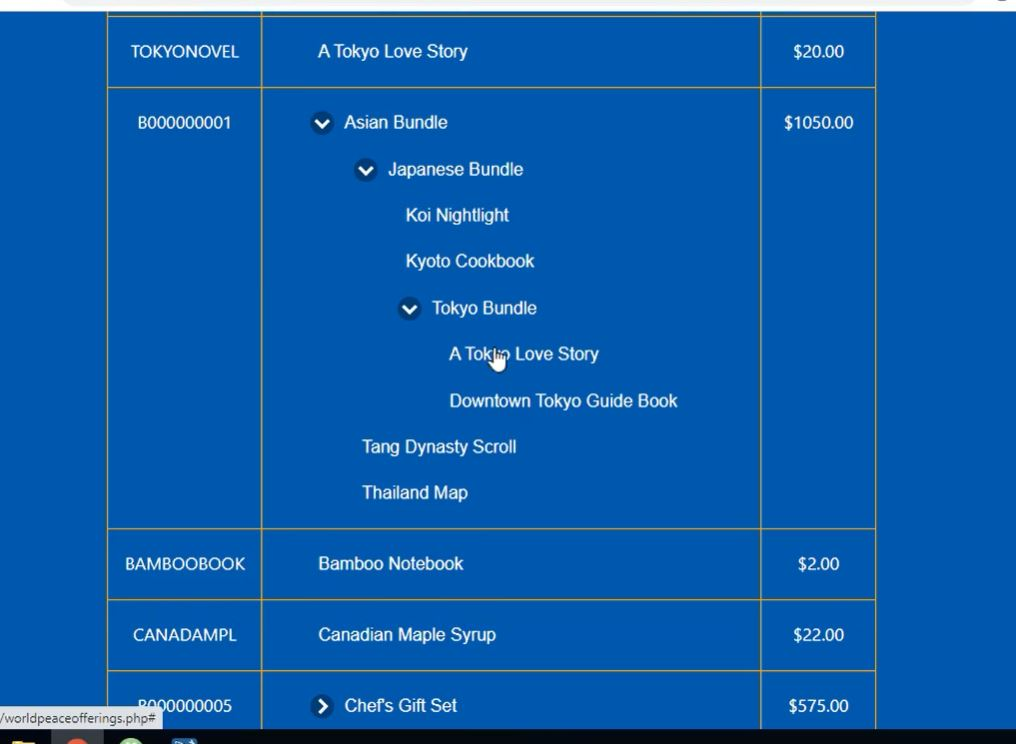

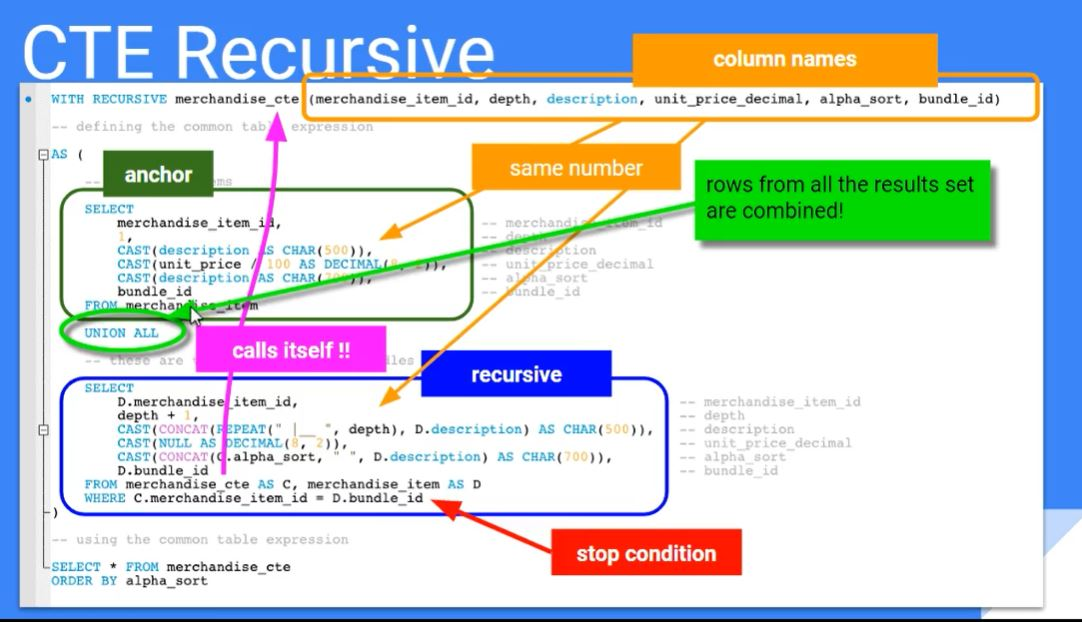

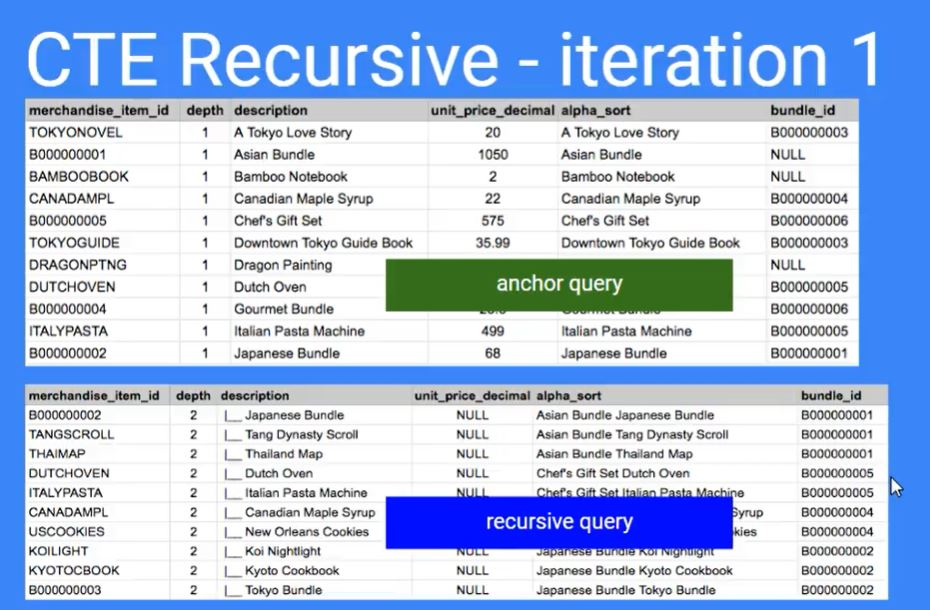

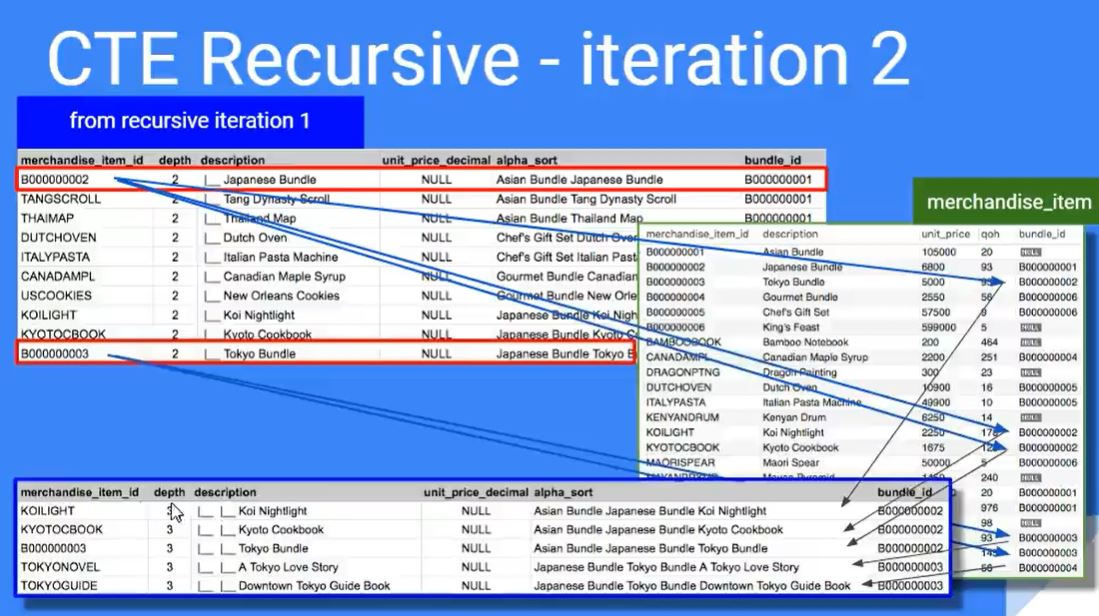

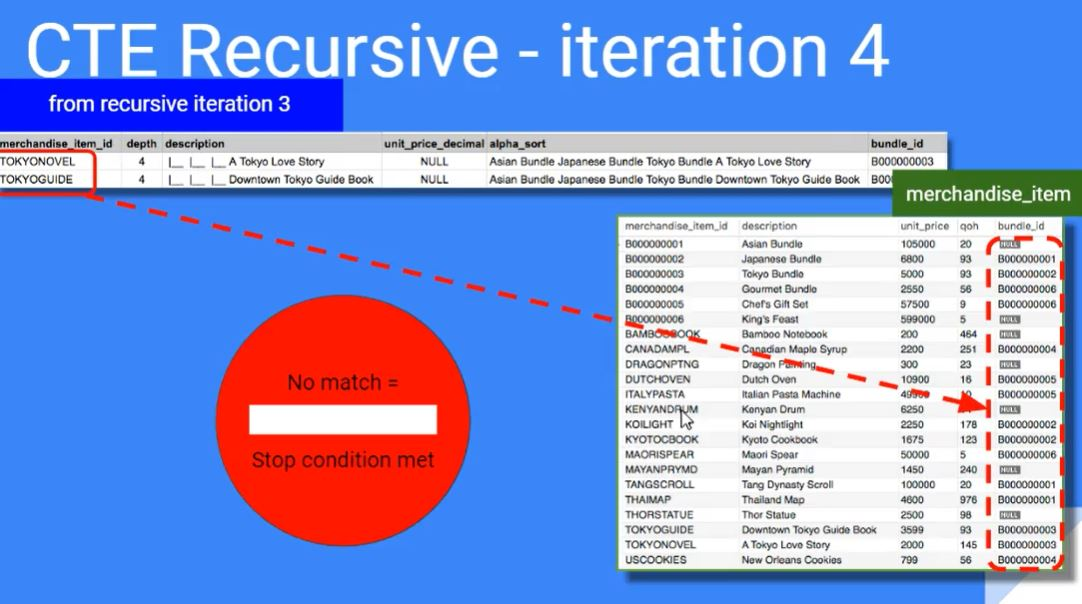

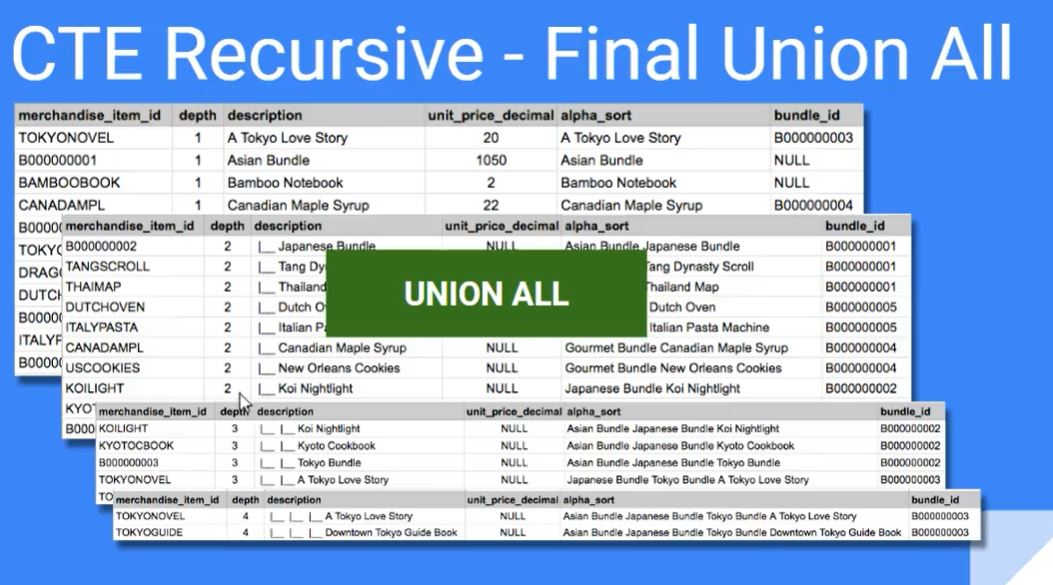

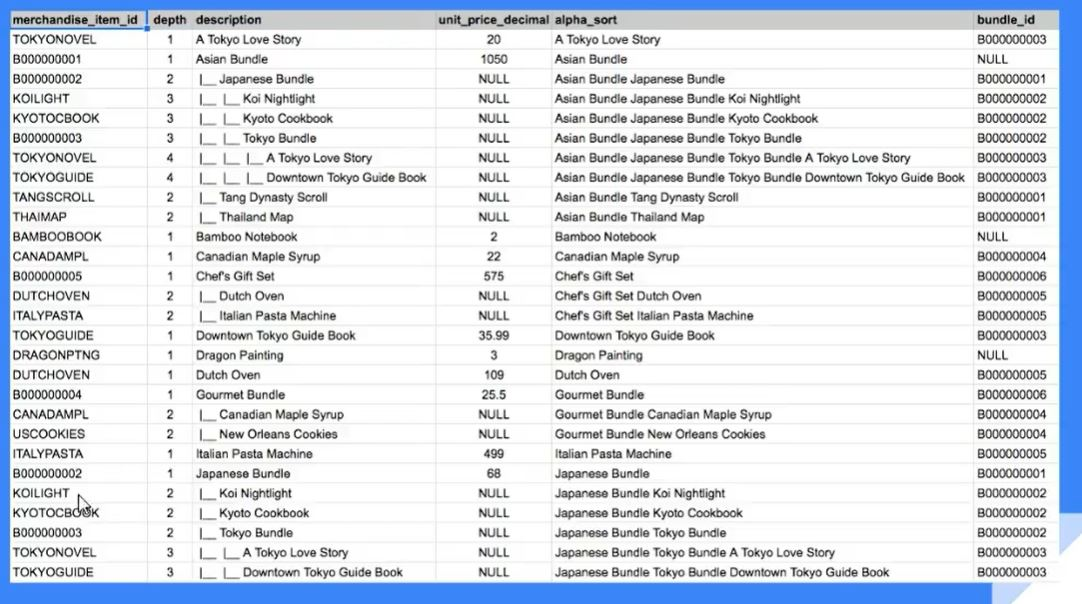

--
-- Welcome to Task 7 !!
--
-- Advanced RDB and SQL
--
-- CTE Recursive Part A
-- 
-- (Non Recursive Example)
-- 

USE world_peace;

WITH merchandise_cte (merchanise_item_id, description, unit_price_decimal, alpha_sort, bundle_id)

-- defining the common table expression

AS ( 

	-- top level items
    
	SELECT 
		merchandise_item_id,
		description,
		unit_price / 100 as unit_price_decimal,
		description AS alpha_sort,
		bundle_id -- CAST(NULL AS CHAR(10))
	FROM merchandise_item

	UNION ALL

	-- these are the children of the bundles

	SELECT 
		D.merchandise_item_id AS merchandise_item_id,
		CONCAT(" |__ ", D.description) AS description,
		NULL AS unit_price_decimal,
		CONCAT(C.description, " ", D.description) AS alpha_sort,
		D.bundle_id
	FROM merchandise_item as C, merchandise_item as D
	WHERE C.merchandise_item_id = D.bundle_id
)

-- using the common table expression

SELECT * FROM merchandise_cte
ORDER BY alpha_sort

--
-- Welcome to Task 7 !!
--
-- Advanced RDB and SQL
--
-- CTE Recursive Part B
--

USE world_peace;

WITH RECURSIVE merchandise_cte (merchandise_item_id, depth, description, unit_price_decimal, alpha_sort, bundle_id)

-- defining the common table expression

AS ( 

	-- top level items

	SELECT 
		merchandise_item_id,						-- merchandise_item_id
		1,											-- depth
		CAST(description AS CHAR(500)),				-- description
		CAST(unit_price / 100 AS DECIMAL(8, 2)),	-- unit_price_decimal
		CAST(description AS CHAR(700)), 			-- alpha_sort
		bundle_id									-- bundle_id
	FROM merchandise_item

	UNION ALL

	-- these are the contents of the bundles

	SELECT 
		D.merchandise_item_id,												-- merchandise_item_id
		depth + 1,															-- depth
		CAST(CONCAT(REPEAT(" |__ ", depth), D.description) AS CHAR(500)),	-- description
		CAST(NULL AS DECIMAL(8, 2)),										-- unit_price_decimal
		CAST(CONCAT(C.alpha_sort, " ", D.description) AS CHAR(700)),    	-- alpha_sort
		D.bundle_id															-- bundle_id
	FROM merchandise_cte AS C, merchandise_item AS D
	WHERE C.merchandise_item_id = D.bundle_id
)

-- using the common table expression

SELECT * FROM merchandise_cte
ORDER BY alpha_sort 